# Problem Statement

Sometimes a person makes a doctor appointments **in Brazil** but fail to show up. It could be a serious issue as patients not showing up may have critical disease and later may have health troubles. So the aim here is to identify what are the kind of persons who fails to show up in Doctor's appointment.


# Possible Questions Needs to be Explored

Possible Questions we will explore here are:

Q1. Are age of person and gender dependent on whether a person show-up?

Q2. Are scholarship/monetary benefits obtained from **Bolsa Família** Program of Goverenment encouraging to a large extent the people to go to doctor. It is because we suspect that many people may ultimately cancel their appointments due to lack of money.

Q3. Does SMS Alert received for the appointment help in reducing no-show?

Q4. How much people with very critical health condition miss their appointments?

Q5. People of which neighbourhoods are more prone to no-show?

In [124]:
!ls

noshowappointments-kagglev2-may-2016.csv  sample_data


In [0]:
# importing the requisite libraries and reading the data
import numpy as np
import pandas as pd
df=pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

In [126]:
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [127]:
#Examining the whole DataFrame
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


# Q1. Are age of person and gender dependent on whether a person show-up?

In [128]:
# Examining thr 'Age' Attribute 
df.Age.describe()

count    110527.000000
mean         37.088874
std          23.110205
min          -1.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: Age, dtype: float64

In [129]:
# Examining the ages of different values in details
df.Age.unique()

array([ 62,  56,   8,  76,  23,  39,  21,  19,  30,  29,  22,  28,  54,
        15,  50,  40,  46,   4,  13,  65,  45,  51,  32,  12,  61,  38,
        79,  18,  63,  64,  85,  59,  55,  71,  49,  78,  31,  58,  27,
         6,   2,  11,   7,   0,   3,   1,  69,  68,  60,  67,  36,  10,
        35,  20,  26,  34,  33,  16,  42,   5,  47,  17,  41,  44,  37,
        24,  66,  77,  81,  70,  53,  75,  73,  52,  74,  43,  89,  57,
        14,   9,  48,  83,  72,  25,  80,  87,  88,  84,  82,  90,  94,
        86,  91,  98,  92,  96,  93,  95,  97, 102, 115, 100,  99,  -1])

We know the age of person normally ranges from0-100. But here are some strange values like **102,115,-1** etc. Now we heard that some people are strong enough to live for more than 100 years. Also these very old people need more medical care. So we keep those records. But -1 is totally absurd, it's probably a typo so we drop it.

In [130]:
# Examining the record of person with Age -1
df[df['Age']==-1]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


In [0]:
# Dropping the person with age '-1'
df1=df.drop(df.index[[99832]])

In [0]:
# Binning ages into categories: Youth [0-17), 
bins = [18, 37, 55, 116]
bin_names = ['Youth', 'Adult', 'Senior']
new_cats = pd.cut(df1['Age'], bins,labels=bin_names,right=False)

In [0]:
df1['Age_Cat']=new_cats

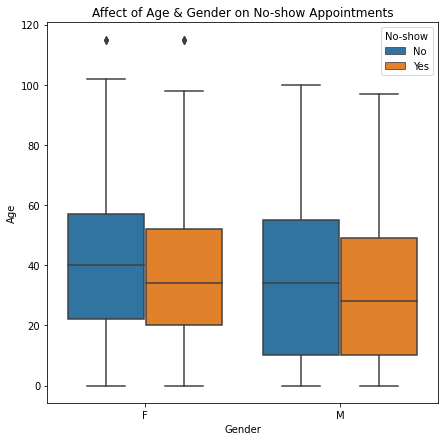

In [134]:
# Visualizing the relationship between age and gender on no-shows with boxplot
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(7,7))
plot=sns.boxplot(data=df1,x='Gender',y='Age',hue='No-show')
plot_title=plt.title('Affect of Age & Gender on No-show Appointments')

We see that across both genders the no-shows people are generally little older than people who shows up. Also the variation in age-groups for both show and no-show is little greater in case of male compared to females as they have greater IQR of age distribution.

We need to perform Hypothesis Testing to see if the tendency/behaviour of both the Genders across varying age is same for turning-up or missing the appointment.

In [135]:
df2=df1[['Age','No-show','Gender']]
df2.head()

,Age,No-show,Gender
0,62,No,F
1,56,No,M
2,62,No,F
3,8,No,F
4,56,No,F


In [0]:
# Calculating Percentage of People Across Gender who shows and don't show up
df3=df2.groupby('Gender')['No-show'].value_counts(normalize=True).reset_index(name='NoshowPerc')
df3['NoshowPerc']*=100

In [0]:
df3['Age']=df2.groupby(['Gender','No-show'])['Age'].mean().reset_index()['Age']

In [138]:
# This DataFrame contains mean age of both the Genders in the DataFrame and the percentage of people turning up/ not turning up for appointment.
df3

,Gender,No-show,NoshowPerc,Age
0,F,No,79.685129,39.591126
1,F,Yes,20.314871,36.162190
2,M,No,80.032052,34.461372
3,M,Yes,19.967948,30.833010


We will perform **Chi-Square Test of Independence** to see if the two groups (male and female) have the same characterisitcs.

**Null Hypothesis (H_0):** There is no difference among Genders across different ages on their tendency to miss appointments.

**Alternate Hypothesis (H_a):** There is difference among Genders across different ages on their tendency to miss appointments.

In [0]:
# Preparing Data for Hypothesis Testing
F=np.hstack([df3.iloc[0,2:4],df3.iloc[1,2:4]])
M=np.hstack([df3.iloc[2,2:4],df3.iloc[3,2:4]])

In [140]:
# Performing the Hypothesis Test
import scipy.stats as stats
arr=np.array([F,M])
chi_sq_stat,p_value,deg_freedom,exp_freq=stats.chi2_contingency(arr)
print('The t-statistic is {}, the p value is {}.'.format(chi_sq_stat,p_value))

The t-statistic is 0.4626925344550018, the p value is 0.9270078322939971.


The p value is greater than 0.05 so we fail to reject the null hypothesis. So there isn't much difference between the two Genders of varying age who turn-up or misses the appointment.

# Q2. What is the impact of Scholarship on Showing up for Appointments?

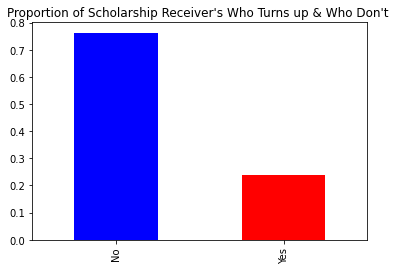

In [141]:
# Visualizing the tendency of proportion of people who got the scholarship 
df[df['Scholarship']==1]['No-show'].value_counts(normalize=True).plot(kind='bar',color=['b','r'])
plt_tit=plt.title('Proportion of Scholarship Receiver\'s Who Turns up & Who Don\'t ')

We can see most of the people who receive the scholarship turns up for appointments.

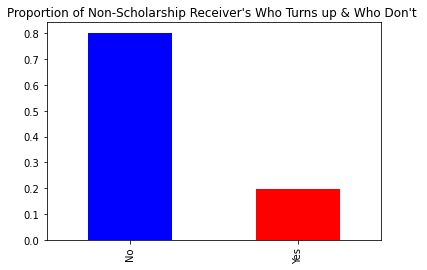

In [142]:
df[df['Scholarship']==0]['No-show'].value_counts(normalize=True).plot(kind='bar',color=['b','r'])
plt_tit=plt.title('Proportion of Non-Scholarship Receiver\'s Who Turns up & Who Don\'t ')

In [143]:
df[df['Scholarship']==1]['No-show'].value_counts(normalize=True)

No     0.762637
Yes    0.237363
Name: No-show, dtype: float64

In [144]:
df[df['Scholarship']==0]['No-show'].value_counts(normalize=True)

No     0.801928
Yes    0.198072
Name: No-show, dtype: float64

The proportion of people who received don't receive scholarship but turned up are greater than those who received the scholarship and turned up. We need to perform Hypothesis Test ( **Two- proportion Test** ) here to see if the difference is significant.

**Null Hypothesis(H_0):** Proportion of People who don't receive scholarship and show up for appointments is same to those who show up for appointments bur not receive scholarship.

**Alternate Hypothesis(H_a):** Proportion of People who show up for appointments but who don't receive scholarship is greater than those who show up for appointments and  receive scholarship.

In [145]:
df5=df.pivot_table(index='Scholarship',columns='No-show',aggfunc={'No-show':'count'})
df5

No-show       
No-show          No    Yes
Scholarship               
0             79925  19741
1              8283   2578

In [146]:
k0=np.array(df5.sum(axis=1))
k0

array([99666, 10861])

In [147]:
# Performing Hypothesis Test
from statsmodels.stats.proportion import proportions_ztest
stats,p_val=proportions_ztest(np.array([df5.iloc[0,0],df5.iloc[1,0]]),np.array([k0[0],k0[1]]),alternative='larger')
print('test statistic is {} and p value is {}'.format(stats,p_val))

test statistic is 9.686116323906157 and p value is 1.727070718058399e-22


So according to result we reject the Null Hypothesis in favour of Alternate Hypothesis and conclude that the proportion of people who turned up even after not receiving scholarship is much greater than people who turned up after receiving scholarship.

**Hence Scholarship has no significant effect on decreasing no shows among patients.**

Even majority of proportion of those who don't receive the scholarship, turn up for appointment.

# Does SMS Alert received for the appointment help in reducing no-show?

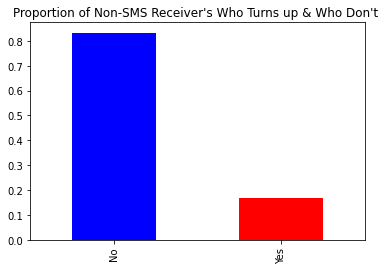

In [148]:
# Checking proportion of people not receiving SMS alert turning-up
df[df['SMS_received']==0]['No-show'].value_counts(normalize=True).plot(kind='bar',color=['b','r'])
plt_tit1=plt.title('Proportion of Non-SMS Receiver\'s Who Turns up & Who Don\'t ')

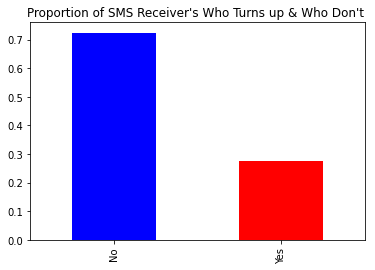

In [149]:
# Checking proportion of people receiving SMS alert turning-up
df[df['SMS_received']==1]['No-show'].value_counts(normalize=True).plot(kind='bar',color=['b','r'])
plt_tit1=plt.title('Proportion of SMS Receiver\'s Who Turns up & Who Don\'t ')

We need to perfom Hypothesis Testing to figure out if SMS alert has significant effect on reducing no show appointments. We will again perform **Two-Proportion Test** Here.

**Null Hypothesis(H_0):** The proportion of people who receive SMS and turn up for appointments is same as those who not receive SMS but also turn up.

**Alternate Hypothesis(H_a):** The proportion of people who receive SMS and turn up for appointments is not same as those who not receive SMS but also turn up.

In [150]:
df4=df.pivot_table(index='SMS_received',columns='No-show',aggfunc={'No-show':'count'})
df4

No-show       
No-show           No    Yes
SMS_received               
0              62510  12535
1              25698   9784

In [0]:
k1=np.array(df4.sum(axis=1))


In [152]:
from statsmodels.stats.proportion import proportions_ztest
print('Proportion of people who receive SMS and show up is {} and who don\'t receive SMS and show up is {}'.format(df4.iloc[0,0]/k1[0],df4.iloc[1,0]/k1[1]))
stats,p_val=proportions_ztest([df4.iloc[0,0],df4.iloc[1,0]],[k1[0],k1[1]])
print('test statistic is {} and p value is {}'.format(stats,p_val))

Proportion of people who receive SMS and show up is 0.8329668865347458 and who don't receive SMS and show up is 0.7242545516036301
test statistic is 42.03263222747829 and p value is 0.0


As before we again do the same procedure and perform Hypothesis Testing and reject the null hypothesis in favour of alternate hypothesis. **We conclude that SMS have a good impact on reducing no-show appointments.**

# How much people with very critical health condition miss their appointments?



Here we will see how many patients with critical health condition do not turn up. Here critical conditions means patients victims of one or more of the mentioned diseases in the dataset i.e, **HiperTension** , **Diabetes** or **Alcoholism**. 

In [0]:
# Sum disease denotes count of people with critical health conditions. Those who possess one of the above mentioned disease have 1 in thier respective row otherwise 0. So we can add
# them up for all patients. If it comes up 0 then the patient is not victim of above disease otherwise thwy might have one of them(1- Little more Critical), 
# combination of two of them(2- Quite Critical) or all three of them(3- Most Critical)
df['Sum_Disease']=df['Hipertension']+df['Diabetes']+df['Alcoholism']

In [0]:
# Creating a dataframe of only those who don't turn up 
df1=df[df['No-show']=='Yes']

In [155]:
# Grouping by proportion of patients with different critical level who don't show up
df2=df1.groupby(df['No-show'])['Sum_Disease'].value_counts(normalize=True).reset_index(name='No-show_Prop')
df2

,No-show,Sum_Disease,No-show_Prop
0,Yes,0,0.799229
1,Yes,1,0.140194
2,Yes,2,0.058515
3,Yes,3,0.002061


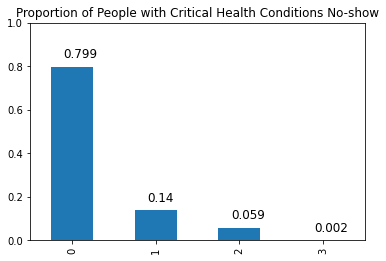

In [156]:
df1.groupby(df['No-show'])['Sum_Disease'].value_counts(normalize=True).reset_index(name='No-show_Prop')['No-show_Prop'].plot(kind='bar')
plt.ylim(0,1)
for i, v in enumerate(df2['No-show_Prop'].tolist()):
    plt.text( i-0.1,v+0.0393, str(round(v,3)), color='black',fontsize=12)
g3=plt.title('Proportion of People with Critical Health Conditions No-show')

We see that almost all of people who have very critical health condition (2,3) don't usually miss their appointments, which is a very good thing. 

Focus should be made on people who are not that critical.They tend to miss up appointments more. 14 % People with 1 critical disease miss up appointments. We should target this group first as neglecting medical attention may later complicate the situation.

In [157]:
(pd.crosstab(df['No-show'],df['Sum_Disease']).iloc[1]/pd.crosstab(df['No-show'],df['Sum_Disease']))

Sum_Disease,0,1,2,3
No-show,,,,
No,0.264368,0.216495,0.215121,0.219048
Yes,1.000000,1.000000,1.000000,1.000000


# People of which neighbourhoods are more prone to no-show?

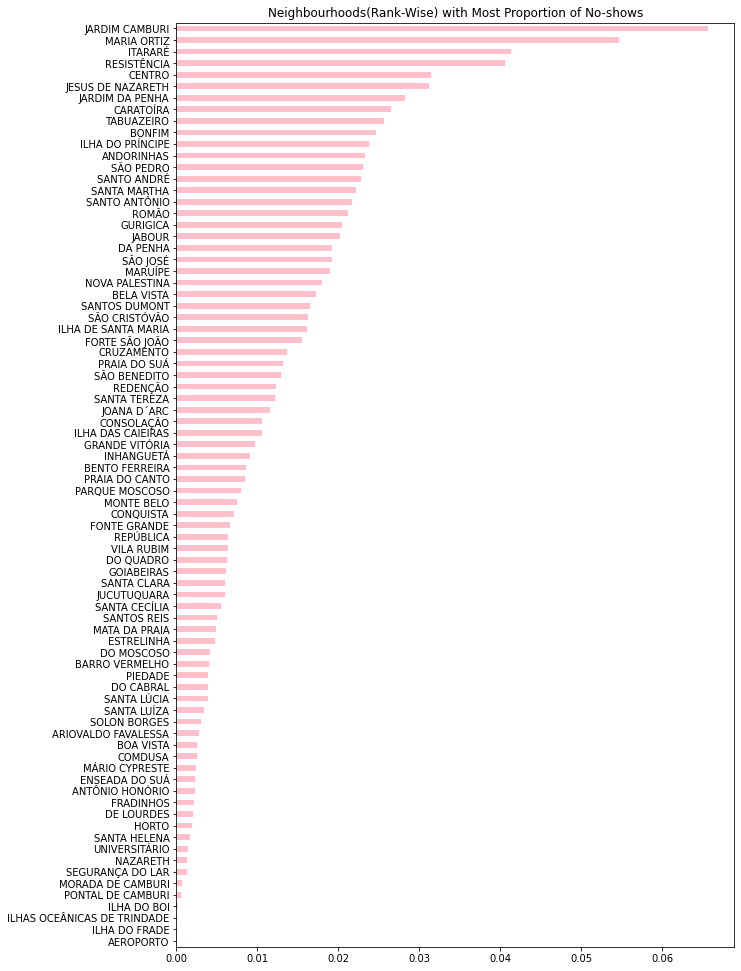

In [158]:
plt.figure(figsize=(10,17))
df[df['No-show']=='Yes']['Neighbourhood'].value_counts(normalize=True)[::-1].plot(kind='barh',color='pink')
plt.tit3=plt.title('Neighbourhoods(Rank-Wise) with Most Proportion of No-shows')

In the above barplot we can see the neighbourhood are arranged in descending order of their number of no-shows.Neighbourhood *JARDIM CAMBURI* has largest number of no-shows followed by others.

# SUMMARY & INFERENCE

1. There is not much differnce on characteristic of people across Gender of different ages on no-show.

2. Scholarship failed to decrease no-show rate.

3. SMS alert has positive imact on on show rate.

4. Though people with very critical health condition do not generally miss their appointments but people will little critical health condition should also not miss them as it may later escalate their health issues.